## <center> Ordinary differential equations </center>

SciPy features two different interfaces to solve differential equations: odeint and solve_ivp. The newer one is solve_ivp and it is recommended but odeint is still widespread, probably because of its simplicity. The primary advantage is that solve_ivp offers several methods for solving differential equations whereas odeint is restricted to one. 

For stiff-ODE's solve_ivp is the better between the two different interfaces, mainly to the fact, that the solver can be changed and adjusted to the ODE to be solved. 

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

### odeint

ODEINT requires three inputs:
- **model**: Function name that returns derivative values at requested y and t values as dydt = model(y,t)
- **y0**: Initial conditions of the differential states
- **t**: Time points at which the solution should be reported. Additional internal points are often calculated to maintain accuracy of the solution but are not reported.

As mentioned before, odeint enables to solve a series of non-stiff differential equations.

Ex: Consider the Lotka-Volterra equations for the dynamics of a population of predator and prey animals (a classic example of coupled ODEs). The equations are $\dot{x}(t) = ax − bxy$ and $\dot{y}(t) = cxy − dy$, where $x(t)$ is the number of prey animals and $y(t)$ is the number of predator animals, and the coefficients $a$, $b$, $c$ and $d$ describe the rates of the processes in the model. For example, a is the rate at which prey animals are born, and d is the rate at which predators die. The $b$ and $c$ coefficients are the rates at which predators consume prey and the rate at which the predator population grows at the expense of the prey population, respectively. Note that this is a nonlinear system of ODEs, because of the xy terms.

Text(0, 0.5, 'Number of predators')

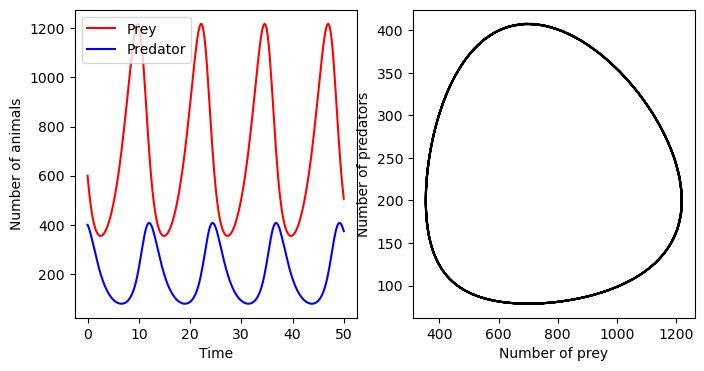

In [2]:
a, b, c, d = 0.4, 0.002, 0.001, 0.7

def f(vars, t, a, b, c, d): # Function
    x = vars[0]
    y = vars[1]

    dxdt = a*x - b*x*y
    dydt = c * x * y - d * y
    return [dxdt, dydt]

vars0 = [600, 400] # Initial conditions
t = np.linspace(0, 50, 250) # time vector for integration
sol = odeint(f, vars0, t, args=(a,b,c,d))
x = sol[:,0]
y = sol[:,1]


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(t, x, 'r', label="Prey")
axes[0].plot(t, y, 'b', label="Predator")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of animals")
axes[0].legend()
axes[1].plot(x, y, 'k')
axes[1].set_xlabel("Number of prey")
axes[1].set_ylabel("Number of predators")

Ex: Solve the following system of ODE's with step integration

$$ 2 \frac{dx(t)}{dt} = -x(t) + u(t)$$
$$ 5 \frac{dy(t)}{dt} = -y(t) + x(t)$$

With the initial conditions: $u = 2*S(t-5)$, $x(0) = 0$, $y(0)=0$, where $S(t-5)$ is a step function that changes from zero to one at $t=5$. When it is multiplied by two, it changes from zero to two at that same time, $t=5$. 

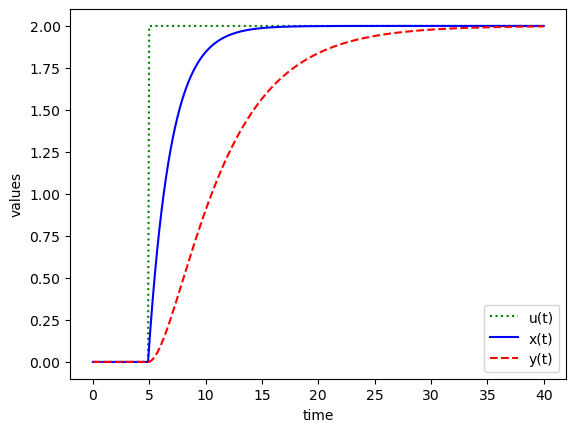

In [3]:
# function that returns dz/dt
def model(z,t,u):
    x = z[0]
    y = z[1]
    dxdt = (-x + u)/2.0
    dydt = (-y + x)/5.0
    dzdt = [dxdt,dydt]
    return dzdt

# initial condition
z0 = [0,0]

# number of time points
n = 401

# time points
t = np.linspace(0,40,n)

# step input
u = np.zeros(n)
# change to 2.0 at time = 5.0
u[50:] = 2.0

# store solution
x = np.empty_like(t)
y = np.empty_like(t)
# record initial conditions
x[0] = z0[0]
y[0] = z0[1]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]]
    # solve for next step
    z = odeint(model,z0,tspan,args=(u[i],))
    # store solution for plotting
    x[i] = z[1][0]
    y[i] = z[1][1]
    # next initial condition
    z0 = z[1]

# plot results
plt.plot(t,u,'g:',label='u(t)')
plt.plot(t,x,'b-',label='x(t)')
plt.plot(t,y,'r--',label='y(t)')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best');

### solve_ivp

solve_ivp requires some imputs, being the most important the following:
1. **model**: Function name that returns derivative values at requested y and t values as dydt = model(y,t)
2. **t_span2**: tuple of floats. Interval of integration (t0, tf). The solver starts with t=t0 and integrates until it reaches t=tf.
3. **y0**: array_like, shape (n,)- Initial state. For problems in the complex domain, pass y0 with a complex data type (even if the initial value is purely real).

4. **method**: Integration method to use:
- ‘RK45’ (default): Explicit Runge-Kutta method of order 5(4). The error is controlled assuming accuracy of the fourth-order method, but steps are taken using the fifth-order accurate formula (local extrapolation is done). A quartic interpolation polynomial is used for the dense output. Can be applied in the complex domain.

- ‘RK23’: Explicit Runge-Kutta method of order 3(2). The error is controlled assuming accuracy of the second-order method, but steps are taken using the third-order accurate formula (local extrapolation is done). A cubic Hermite polynomial is used for the dense output. Can be applied in the complex domain.

- ‘DOP853’: Explicit Runge-Kutta method of order 8. Python implementation of the “DOP853” algorithm originally written in Fortran. A 7-th order interpolation polynomial accurate to 7-th order is used for the dense output. Can be applied in the complex domain.

- ‘Radau’: Implicit Runge-Kutta method of the Radau IIA family of order 5. The error is controlled with a third-order accurate embedded formula. A cubic polynomial which satisfies the collocation conditions is used for the dense output.

- ‘BDF’: Implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation. The implementation follows the one described in. A quasi-constant step scheme is used and accuracy is enhanced using the NDF modification. Can be applied in the complex domain.

- ‘LSODA’: Adams/BDF method with automatic stiffness detection and switching. This is a wrapper of the Fortran solver from ODEPACK.

Explicit Runge-Kutta methods (‘RK23’, ‘RK45’, ‘DOP853’) should be used for non-stiff problems and implicit methods (‘Radau’, ‘BDF’) for stiff problems. Among Runge-Kutta methods, ‘DOP853’ is recommended for solving with high precision (low values of rtol and atol). If not sure, first try to run ‘RK45’. If it makes unusually many iterations, diverges, or fails, your problem is likely to be stiff and you should use ‘Radau’ or ‘BDF’. ‘LSODA’ can also be a good universal choice, but it might be somewhat less convenient to work with as it wraps old Fortran code.

You can also pass an arbitrary class derived from OdeSolver which implements the solver.

5. **t_eval**: Times at which to store the computed solution, must be sorted and lie within t_span. If None (default), use points selected by the solver.

Ex: A classic example of a stiff system of ODEs is the kinetic analysis of Robertson's autocatalytic chemical reaction. The reaction involves three species, $x$, $y$ and $z$ with initial conditions $x=1$, $y=z=0$:

$$ \frac{dx}{dt} = -0.04*x + 10^4 yz$$
$$ \frac{dy}{dt} = 0.04*x - 10^4 yz - 3*10^7y^2$$
$$ \frac{dz}{dt} = 3*10^7y^2$$


In [4]:
# Function 
def Robertson_model(t, vals):
    """ODEs for Robertson's chemical reaction system."""
    x = vals[0]
    y = vals[1]
    z = vals[2]

    dxdt = -0.04 * x + 1.e4 * y * z
    dydt = 0.04 * x - 1.e4 * y * z - 3.e7 * y**2
    dzdt = 3.e7 * y**2

    dvdt = [dxdt, dydt, dzdt]
    return dvdt

# Initial conditions
vals0 = [1, 0, 0]

# Time integration tuple
t0, tf = 0, 500
t_tuple = (t0, tf)


# With the default Runge–Kutta algorithm on the time interval [0,500]
soln = solve_ivp(Robertson_model, t_tuple, y0= vals0, method="RK45")
soln

  message: 'Required step size is less than spacing between numbers.'
     nfev: 5888
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 6.36669332e-04, 1.27333866e-03, 2.20213282e-03,
       3.13092697e-03, 4.80969904e-03, 6.37101851e-03, 7.93233798e-03,
       9.28576609e-03, 1.06391942e-02, 1.22959348e-02, 1.35375361e-02,
       1.47791374e-02, 1.66553843e-02, 1.78374030e-02, 1.90194216e-02,
       2.12214427e-02, 2.23807443e-02, 2.35400458e-02, 2.57819566e-02,
       2.68773508e-02, 2.79727450e-02, 3.03601871e-02, 3.10720278e-02,
       3.17838684e-02, 3.43224058e-02, 3.48661863e-02, 3.54099668e-02,
       3.76349423e-02, 3.84638818e-02, 3.92928212e-02, 4.14521125e-02,
       4.30061029e-02, 4.42404541e-02, 4.54748052e-02, 4.72418285e-02,
       4.84912237e-02, 4.97406190e-02, 5.18122417e-02, 5.29066395e-02,
       5.40010374e-02, 5.62750489e-02, 5.71750119e-02, 5.80749749e-02,
       6.07032556e-02, 6.13100444e-02, 6.19168332

In this case, the model doesn't converge --> stiff-ODE!!

In [5]:
# Solve, using a method resilient to stiff ODEs.
soln = solve_ivp(Robertson_model, t_tuple, y0= vals0, method="Radau")
soln

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 248
     njev: 14
      nlu: 60
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 7.06687545e-04, 1.47212739e-03, 2.61769904e-03,
       3.80990518e-03, 7.40319796e-03, 1.99267896e-02, 9.15996723e-02,
       3.15875243e-01, 9.63978728e-01, 1.61208221e+00, 2.95571445e+00,
       4.72814422e+00, 7.40529929e+00, 1.10497341e+01, 1.66228035e+01,
       2.43514285e+01, 3.62943482e+01, 5.30400728e+01, 7.90939122e+01,
       1.15745280e+02, 1.72751311e+02, 2.52482777e+02, 3.75561677e+02,
       5.00000000e+02])
 t_events: None
        y: array([[1.00000000e+00, 9.99971733e-01, 9.99941120e-01, 9.99895320e-01,
        9.99847678e-01, 9.99704224e-01, 9.99205871e-01, 9.96401276e-01,
        9.88109550e-01, 9.67486595e-01, 9.50502897e-01, 9.22677952e-01,
        8.95131152e-01, 8.64275992e-01, 8.33393593e-01, 7.98937837e-01,
        7.64261812e-01, 7.25604494e-01, 6.86701710e-01

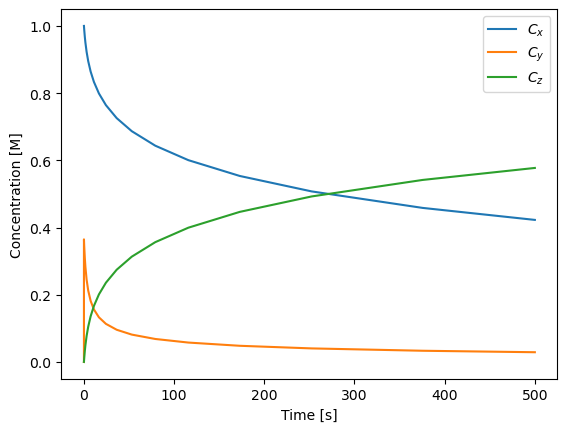

In [6]:
# Plotting
x = soln.y[0]
y = soln.y[1]*10**4
z = soln.y[2]

plt.plot(soln.t, x, label='$C_x$')
plt.plot(soln.t, y, label='$C_y$')
plt.plot(soln.t, z, label='$C_z$')
plt.xlabel('Time [s]')
plt.ylabel('Concentration [M]')
plt.legend()


-----
### ODE solution with GEKKO

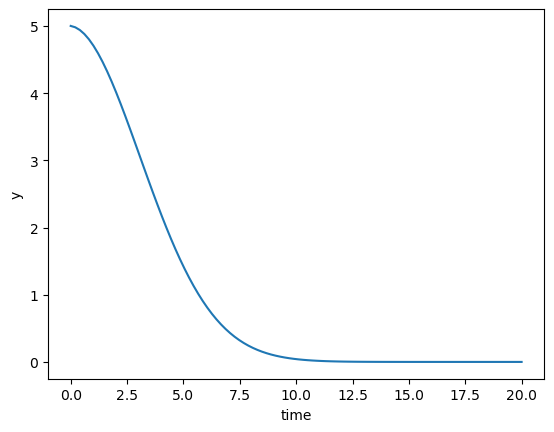

In [7]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

m = GEKKO()
k = 10
m.time = np.linspace(0,20,100)

y = m.Var(value=5)
t = m.Param(value=m.time)
m.Equation(k*y.dt()==-t*y)
m.options.IMODE=4 # ODE solver
m.solve(disp=False)

plt.plot(m.time,y.value)
plt.xlabel('time')
plt.ylabel('y')
plt.show()